In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import pathlib as pl
from skimage.io import imread
from skimage.transform import resize
from keras.api.models import Sequential, Model
from keras.api.applications.vgg16 import VGG16, preprocess_input
from keras.api.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.api.layers import GlobalMaxPooling2D
from keras.api.layers import BatchNormalization
from keras.api.layers import Concatenate
from keras.api.models import Model
from keras.api.optimizers import Adam, SGD, RMSprop
from keras.api.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.api.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
import tensorflow as tf
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

In [5]:
seed = 0

os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
aug.seed(seed)

In [7]:
data_dir = pl.Path('C:/programming/data-science/machine-learning-projects/pneumonia-xray/data')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

## EDA

In [8]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_files = []
for img in normal_cases:
    train_files.append((img, 0))

for img in pneumonia_cases:
    train_files.append((img, 1))

train_data = pd.DataFrame(train_files, columns=['image', 'label'], index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

,image,label
0,C:\programming\data-science\machine-learning-p...,1
1,C:\programming\data-science\machine-learning-p...,1
2,C:\programming\data-science\machine-learning-p...,1
3,C:\programming\data-science\machine-learning-p...,1
4,C:\programming\data-science\machine-learning-p...,0


label
1    3875
0    1341
Name: count, dtype: int64


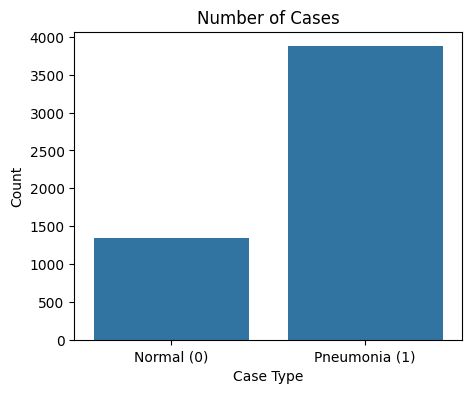

In [12]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of Cases', fontsize=12)
plt.xlabel('Case Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(len(cases_count.index)), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

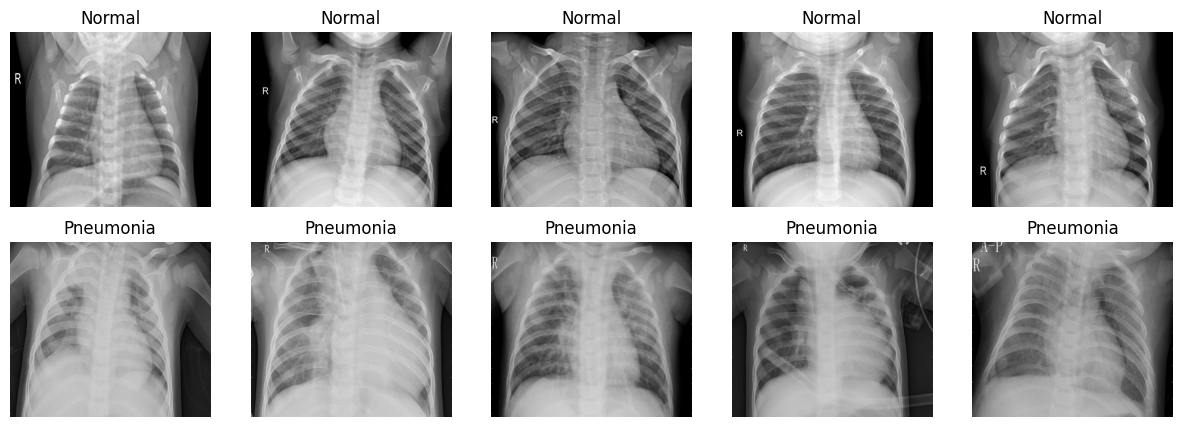

In [15]:
normal_samples = train_data.query('label == 0')['image'].iloc[:5].to_list()
pneumonia_samples = train_data.query('label == 1')['image'].iloc[:5].to_list()
samples = normal_samples + pneumonia_samples

fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i, s in enumerate(samples):
    img = imread(s)

    row = i // 5
    col = i % 5
    axes_i:plt.Axes = ax[row, col]
    axes_i.imshow(img, cmap='gray')

    title_i = 'Normal' if i < 5 else 'Pneumonia'
    axes_i.set_title(title_i)
    axes_i.axis('off')
    axes_i.set_aspect('auto')

plt.show()

## Prepare Validation Data